<h1>Sparse Convolutional Denoising Autoencoders for Genotype Imputation <span class="tocSkip"></span></h1>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Sample-visualization" data-toc-modified-id="Sample-visualization-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sample visualization</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Method" data-toc-modified-id="Method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#Prediction-on-test-data" data-toc-modified-id="Prediction-on-test-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prediction on test data</a></span></li></ul></div>

# Introduction

Genotype imputation, where missing genotypes can be computationally imputed, is an essential tool in genomic analysis ranging from genome wide associations to phenotype prediction. Traditional genotype imputation methods are typically based on Hidden Markov Models (HMMs) and are usually computationally expensive. Deep learning-based methods have been recently reported to nicely address the missing data problems in various fields. To explore the performance of deep learning for genotype imputation, in this study we propose a deep model called a Sparse Convolutional Denoising Autoencoder (SCDA) to impute missing genotypes. We constructed the SCDA model by using a convolutional layer that can extract various correlation or linkage patterns in the genotype data and applying a sparse weight matrix resulted from the L1 regularization to handle high dimensional data. We comprehensively evaluated the performance of the SCDA model in different scenarios for genotype imputation on the yeast and human genotype data respectively. Our results showed that SCDA has strong robustness and significantly outperforms three popular reference-free imputation methods including row average, k-nearest neighbors and singular-value decomposition. This study thus points to another novel application of deep learning models for missing data imputation in genomic studies. 

In [1]:
%matplotlib inline   
from matplotlib import pyplot as plt
import pylab as pl
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling1D, UpSampling2D, AveragePooling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1, l1, l1_l2
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# specify a seed for repeating the exact dataset splits
np.random.seed(seed=28213)

# Dataset

## Loading data

In [3]:
input_name = 'data/genotype_full.txt'
df_ori = pd.read_csv(input_name, sep='\t', index_col=0)
df_ori.shape

(4390, 28220)

In [4]:
df_ori.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,12048853_chrXVI_925593_G_C,12049199_chrXVI_925939_T_C,12049441_chrXVI_926181_C_T,12050613_chrXVI_927353_T_G,12051167_chrXVI_927907_A_C,12051240_chrXVI_927980_A_G,12051367_chrXVI_928107_C_T,12052782_chrXVI_929522_C_T,12052988_chrXVI_929728_A_G,12053130_chrXVI_929870_C_T
SAMID,,,,,,,,,,,,,,,,,,,,,
01_01,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
01_02,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
01_03,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_06,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [5]:
# # take a small part to test code
# df_ori = df_ori.iloc[0:1000:, 0:5000]

## Sample visualization

In [6]:
# the first sample in dataset
vis_sample=df_ori.iloc[0].values[:28220].reshape(166,170)

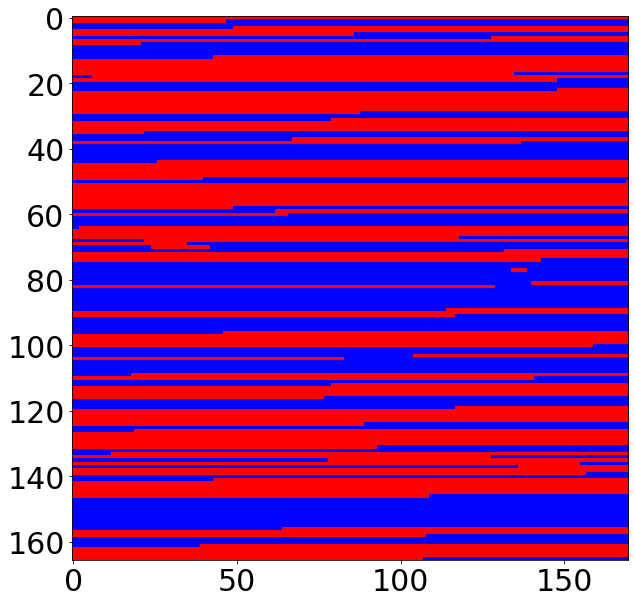

In [7]:
# draw first train sample, which was reshaped to (50,100)
plt.figure(figsize=(10, 10))
ax = plt.gca()
cmap = mpl.colors.ListedColormap([ 'blue', 'red'])
im = ax.imshow(vis_sample, cmap=cmap)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
plt.tick_params(labelsize=30)
plt.rcParams["font.family"] = ['Times New Roman'] + plt.rcParams['font.serif']
# plt.colorbar(im, cax=cax)
plt.show()

## Preprocessing

In [8]:
# replace -1 with 0, because OneHot can't encode negative number 
df_ori[df_ori == -1] = 0

In [9]:
# one hot encode
df_onehot = to_categorical(df_ori)
df_onehot.shape

(4390, 28220, 2)

In [10]:
# split df to train and test
train_X, test_X = train_test_split(df_onehot, test_size=0.2)

train_X.shape, test_X.shape

((3512, 28220, 2), (878, 28220, 2))

In [11]:
# split df to train and valid
train_X, valid_X = train_test_split(train_X, test_size=0.2)

train_X.shape, valid_X.shape

((2809, 28220, 2), (703, 28220, 2))

# Method

## Build model

In [12]:
# hyperparameters
missing_perc = 0.1

# training
batch_size = 32
lr = 1e-3
epochs = 20

# conv1D
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
kr = 1e-4
drop_prec = 0.25

In [13]:
SCDA = Sequential()
# encoder
SCDA.add(Conv1D(32, 5, padding='same',activation='relu',kernel_regularizer=l1(kr),input_shape=(feature_size, inChannel)))
SCDA.add(MaxPooling1D(pool_size=2))
SCDA.add(Dropout(drop_prec))
          
SCDA.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(MaxPooling1D(pool_size=2)) 
SCDA.add(Dropout(drop_prec))

# bridge
SCDA.add(Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr)))

# decoder
SCDA.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(UpSampling1D(2)) 
SCDA.add(Dropout(drop_prec))
          
SCDA.add(Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(UpSampling1D(2))
SCDA.add(Dropout(drop_prec))

SCDA.add(Conv1D(inChannel, 5, activation='softmax', padding='same',kernel_regularizer=l1(kr))) 


# compile
SCDA.compile(loss='categorical_crossentropy', 
                    optimizer='adam',
                    metrics=['accuracy'])

SCDA.summary()

W0730 21:26:10.189944 4512404928 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28220, 32)         352       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14110, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14110, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14110, 64)         10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7055, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7055, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7055, 128)         4

## Generate data 

In [14]:
# Generates data for denoising autoencoder.
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        # triggered once at the very beginning as well as at the end of each epoch.
        self.on_epoch_end()

    def __len__(self):
        # Denote the number of batches per epoch
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        # Generates one batch of data
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        # Generates missing genotypes
        # different missing loci for each individuals
        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            # missing loci are encoded as [0, 0]
            self.x_missing[i, missing_index, :] = 0

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        # Update indexes after each epoch
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [15]:
train_generator = DataGenerator(
    batch_size=batch_size, x_dataset=train_X, missing_perc=missing_perc)
valid_generator = DataGenerator(
    batch_size=batch_size, x_dataset=valid_X, missing_perc=missing_perc)

## Training

In [16]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/SCDA_checkpoint.{epoch:02d}-{val_acc:.4f}.h5',
    monitor='val_acc',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

W0730 21:26:16.914561 4512404928 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [17]:
SCDA_train = SCDA.fit_generator(
    generator=train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    verbose=1,
#     callbacks=[EarlyStopping, ModelCheckpoint]
)

Epoch 1/20


W0730 21:26:20.901879 4512404928 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


87/87 [==============================] - 402s 5s/step - loss: 0.3588 - acc: 0.9848 - val_loss: 0.2096 - val_acc: 0.9993
Epoch 2/20
87/87 [==============================] - 237s 3s/step - loss: 0.1569 - acc: 0.9982 - val_loss: 0.1135 - val_acc: 0.9993
Epoch 3/20
87/87 [==============================] - 236s 3s/step - loss: 0.0902 - acc: 0.9982 - val_loss: 0.0685 - val_acc: 0.9993
Epoch 4/20
87/87 [==============================] - 237s 3s/step - loss: 0.0573 - acc: 0.9982 - val_loss: 0.0454 - val_acc: 0.9993
Epoch 5/20
87/87 [==============================] - 236s 3s/step - loss: 0.0401 - acc: 0.9982 - val_loss: 0.0329 - val_acc: 0.9993
Epoch 6/20
87/87 [==============================] - 235s 3s/step - loss: 0.0304 - acc: 0.9982 - val_loss: 0.0256 - val_acc: 0.9993
Epoch 7/20
87/87 [==============================] - 235s 3s/step - loss: 0.0247 - acc: 0.9982 - val_loss: 0.0212 - val_acc: 0.9993
Epoch 8/20
87/87 [==============================] - 235s 3s/step - loss: 0.0211 - acc: 0.9983 

## Plot

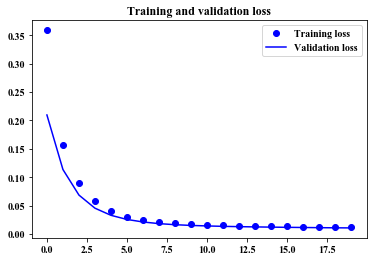

In [18]:
# plot loss curve on validation data
loss = SCDA_train.history['loss']
val_loss = SCDA_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

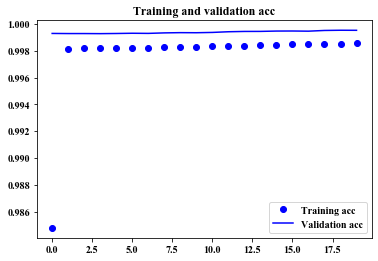

In [19]:
# plot accuracy curve on validation data
acc = SCDA_train.history['acc']
val_acc = SCDA_train.history['val_acc']
plt.figure()
plt.plot(range(len(acc)), acc, 'bo', label='Training acc')
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

# Prediction on test data

In [20]:
test_X_missing = test_X.copy()

In [21]:
accuracy=[]
for i in range(test_X_missing.shape[0]):
    # Generates missing genotypes
    missing_size= int(missing_perc*test_X_missing.shape[1])
    missing_index = np.random.randint(test_X_missing.shape[1], size=missing_size)
    test_X_missing[i, missing_index, :] = 0
    
    # predict
    predict_onehot = SCDA.predict(test_X_missing[i:i+1,:,:])
    # only care the missing position
    predict_missing_onehot = predict_onehot[0:1, missing_index, :]
    predict_missing=np.argmax(predict_missing_onehot, axis=2)
    
    # label
    label_missing_onehot = test_X[i:i+1, missing_index, :]
    label_missing=np.argmax(label_missing_onehot, axis=2)

    # accuracy
    correct_prediction = np.equal(predict_missing, label_missing)
    accuracy.append(np.mean(correct_prediction))

In [22]:
avg_acc=np.mean(accuracy)
print('The average accuracy on test data is {}'.format(avg_acc))

The average accuracy on test data is 0.9979287375954308
